# PART 1

In [2]:
import pandas as pd
import numpy as np
from math import log2
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Reading and Handling Data

In [51]:
path = "financial_risk_assessment.csv"
df = pd.read_csv(path)
df.head()

,Age,Gender,Education Level,Marital Status,Income,Credit Score,Loan Amount,Loan Purpose,Employment Status,Years at Current Job,Payment History,Debt-to-Income Ratio,Assets Value,Number of Dependents,City,State,Country,Previous Defaults,Marital Status Change,Risk Rating
0,49,Male,PhD,Divorced,72799.0,688.0,45713.0,Business,Unemployed,19,Poor,0.154313,120228.0,0.0,Port Elizabeth,AS,Cyprus,2.0,2,Low
1,57,Female,Bachelor's,Widowed,NaN,690.0,33835.0,Auto,Employed,6,Fair,0.148920,55849.0,0.0,North Catherine,OH,Turkmenistan,3.0,2,Medium
2,21,Non-binary,Master's,Single,55687.0,600.0,36623.0,Home,Employed,8,Fair,0.362398,180700.0,3.0,South Scott,OK,Luxembourg,3.0,2,Medium
3,59,Male,Bachelor's,Single,26508.0,622.0,26541.0,Personal,Unemployed,2,Excellent,0.454964,157319.0,3.0,Robinhaven,PR,Uganda,4.0,2,Medium
4,25,Non-binary,Bachelor's,Widowed,49427.0,766.0,36528.0,Personal,Unemployed,10,Fair,0.143242,287140.0,NaN,New Heather,IL,Namibia,3.0,1,Low


"Before training the model, it is essential to check for the presence of missing values, as they must be appropriately addressed to ensure accurate results."

In [6]:
df.isnull().sum()

Age                         0
Gender                      0
Education Level             0
Marital Status              0
Income                   2250
Credit Score             2250
Loan Amount              2250
Loan Purpose                0
Employment Status           0
Years at Current Job        0
Payment History             0
Debt-to-Income Ratio        0
Assets Value             2250
Number of Dependents     2250
City                        0
State                       0
Country                     0
Previous Defaults        2250
Marital Status Change       0
Risk Rating                 0
dtype: int64

"To address the missing data, we chose to impute the mean for numerical columns and the mode for categorical columns. Given that there are 2,250 missing values across 6 columns in a dataset of 15,000 records, removing rows with missing data would result in the loss of at least one-sixth of the dataset. Consequently, filling the missing values was seemed a more suitable approach."

In [8]:
for (columnName,columnData) in df.items():
    if columnData.dtype in ['float64', 'int64']:
        df[columnName] = df[columnName].fillna(columnData.mean())
    else:
        df[columnName] = df[columnName].fillna(columnData.mode()[0])

Due to the presence of numerous non-binary attributes and limited computational capacity, we are unable to include all of our attributes in the model. As a result, we need to focus on the most relevant features. Therefore, we decided to drop the least important columns based on our assessment.

In [10]:
df = df.drop(columns=['City', 'State', 'Country', 'Marital Status Change'])

In accordance with the principles of Decision Tree algorithms, we chose to create average values for certain columns and assign others to the closest category. The idea behind this decision is that some of our columns have an excessive number of unique values, which complicates the splitting process at each node. To address this issue, we decided to limit the maximum number of distinct values allowed in each column, thereby simplifying the model's decision-making process.

In [12]:
def bin_numerical_columns(df, num_bins=7):
    """
    Bins numerical columns into 'num_bins' discrete categories.
    Each numerical value is rounded to the nearest bin based on its range.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - num_bins (int): The number of bins to create for numerical columns.

    Returns:
    - df (pd.DataFrame): The DataFrame with binned numerical columns.
    """
    for column in df.columns:
        # Check if the column is numerical
        if np.issubdtype(df[column].dtype, np.number):
            # Create bins using np.linspace to get evenly spaced bins based on min and max values
            min_val = df[column].min()
            max_val = df[column].max()
            bins = np.linspace(min_val, max_val, num_bins+1)

            # Assign each value to the closest bin
            df[column] = pd.cut(df[column], bins=bins, labels=np.arange(1, num_bins+1), include_lowest=True)

    return df
df = bin_numerical_columns(df)

Since we cannot use external labels, we need to generate our own labels for the data. To do this, we decided to create a custom function that assigns a unique integer to each distinct attribute value, starting from 0 up to n, where n represents the number of unique values in the column. Additionally, we print the key-value pairs of the mappings for reference.

In [14]:
encoding_maps = {}
def dynamic_encode(column):
    encoding_map = {}
    encoded_values = []
    current_max = 0

    for value in column:
        if value not in encoding_map:
            encoding_map[value] = current_max
            current_max += 1
        encoded_values.append(encoding_map[value])

    return encoded_values, encoding_map

for column in df.columns:
    if df[column].dtype == 'object':
        encoded_column, encoding_map = dynamic_encode(df[column])
        df[column] = encoded_column
        encoding_maps[column] = encoding_map
print("="*50)
print("COLUMN ENCODING MAPPINGS")
print("="*50)

for column_name, mapping in encoding_maps.items():
    print(f"\nColumn: {column_name}")
    print("-"*40)
    for value, code in mapping.items():
        print(f"{code:>3} → {value}")
    print(f"Total categories: {len(mapping)}")

COLUMN ENCODING MAPPINGS

Column: Gender
----------------------------------------
  0 → Male
  1 → Female
  2 → Non-binary
Total categories: 3

Column: Education Level
----------------------------------------
  0 → PhD
  1 → Bachelor's
  2 → Master's
  3 → High School
Total categories: 4

Column: Marital Status
----------------------------------------
  0 → Divorced
  1 → Widowed
  2 → Single
  3 → Married
Total categories: 4

Column: Loan Purpose
----------------------------------------
  0 → Business
  1 → Auto
  2 → Home
  3 → Personal
Total categories: 4

Column: Employment Status
----------------------------------------
  0 → Unemployed
  1 → Employed
  2 → Self-employed
Total categories: 3

Column: Payment History
----------------------------------------
  0 → Poor
  1 → Fair
  2 → Excellent
  3 → Good
Total categories: 4

Column: Risk Rating
----------------------------------------
  0 → Low
  1 → Medium
  2 → High
Total categories: 3


The data is split into 70% for training, 15% for validation, and 15% for testing with the help of sklearn library.

In [16]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## ID3 Algorithm

Before the ID3 algorithm is implemented, some helper functions are defined. The entropy function is used to calculate the entropy of the target column, which measures the uncertainty of the data. The info_gain function is used to calculate the information gain for a given feature, helping in the selection of the best feature to split on. By computing the entropy for each feature and selecting the one with the highest information gain, the most informative splits are made at each node of the decision tree.

In [19]:
def entropy(target_col):
    """
    Calculate entropy of a target column
    """
    elements, counts = np.unique(target_col, return_counts=True)
    entropy = -np.sum([(counts[i]/np.sum(counts)) * log2(counts[i]/np.sum(counts))
                      for i in range(len(elements))])
    return entropy

def info_gain(data, feature, target_name):
    """
    Calculate information gain for splitting on a feature
    """
    total_entropy = entropy(data[target_name])

    # Calculate weighted entropy
    vals, counts = np.unique(data[feature], return_counts=True)
    weighted_entropy = np.sum([(counts[i]/np.sum(counts)) *
                             entropy(data.where(data[feature]==vals[i]).dropna()[target_name])
                             for i in range(len(vals))])

    return total_entropy - weighted_entropy

### How ID3 Algorithm Works:

#### 1. Stopping Conditions:
The algorithm stops growing the tree under two conditions:
- If all the instances in the current dataset belong to the same class (i.e., no diversity in the target label), the algorithm terminates and returns the class label of the majority.
- If no features remain to split on or the maximum depth of the tree (`max_depth`) has been reached, the algorithm assigns the most frequent class in the current subset of data.

#### 2. Feature Selection:
At each node, the algorithm calculates the **information gain** for each feature using the entropy of the dataset and selects the feature with the highest information gain to split the data. This helps in finding the best feature that divides the data in a way that maximizes the homogeneity of the resulting subsets.

#### 3. Tree Construction:
The tree is constructed by recursively splitting the data at each node:
- The feature with the highest information gain is selected for the split.
- The dataset is partitioned based on the values of the selected feature.
- This process continues recursively for each subset of the data, creating new nodes in the tree.
- Each node represents a decision based on the selected feature, and the tree is grown until a stopping condition is met.

#### 4. How the ID3 Algorithm Works:
The implementation of the ID3 algorithm works as follows:
1. **Stopping Conditions:** The algorithm checks if the dataset is homogeneous (all instances belong to the same class) or if there are no more features to split on. If either condition is met, the algorithm returns the majority class label.
2. **Feature Selection:** The algorithm calculates the information gain for each feature and selects the feature with the highest gain to split the data.
3. **Recursion:** The dataset is split based on the selected feature, and the process is repeated recursively on each subset. This creates branches in the tree, and the process continues until the stopping conditions are met.
4. **Tree Construction:** The result is a decision tree where each node corresponds to a decision based on a feature, and each leaf node corresponds to a class label.

In [22]:
def id3(data, original_data, features, target_name, max_depth=None, current_depth=0):
    """
    ID3 Algorithm implementation
    """
    # Stopping conditions
    if len(np.unique(data[target_name])) <= 1:
        return np.unique(data[target_name])[0]

    if len(features) == 0 or (max_depth is not None and current_depth == max_depth):
        return np.unique(data[target_name])[np.argmax(np.unique(data[target_name], return_counts=True)[1])]

    # Select best feature
    gains = [info_gain(data, feature, target_name) for feature in features]
    best_feature = features[np.argmax(gains)]

    # Create tree structure
    tree = {best_feature: {}}

    # Remove best feature from features
    features = [f for f in features if f != best_feature]

    # Grow tree recursively
    for value in np.unique(data[best_feature]):
        sub_data = data.where(data[best_feature] == value).dropna()

        if len(sub_data) == 0:
            tree[best_feature][value] = np.unique(original_data[target_name])[
                np.argmax(np.unique(original_data[target_name], return_counts=True)[1])]
        else:
            tree[best_feature][value] = id3(sub_data, original_data, features,
                                           target_name, max_depth, current_depth+1)

    return tree

## Predict Function for ID3 Algorithm

The `predict` function is used to make predictions on new, unseen data using the decision tree that was built by the ID3 algorithm. It traverses the tree based on the feature values of the given sample, starting from the root node and moving down through the tree until it reaches a leaf node with a class label.

### How the `predict` Function Works:

1. **Traversal through the Tree:**
   The function starts by iterating over the keys (features) in the decision tree. Each feature corresponds to a decision point (node) in the tree.

2. **Decision at Each Node:**
   For each feature in the tree, the corresponding value from the input sample (`sample[feature]`) is checked. If the value exists in the current node’s dictionary, the tree moves to the next level, where the value corresponds to a new subtree.

3. **Recursive Traversal:**
   - If the subtree is a dictionary (indicating that the node is not a leaf), the function calls itself recursively to continue the search down the tree.
   - If a leaf node (a class label) is reached, the function returns the predicted class label.

### Purpose:
This function enables the decision tree to make a prediction by following the path dictated by the feature values in the input sample, ultimately returning the predicted class label for classification problems.

In [24]:
def predict(tree, sample):
    """
    Predicts the class label for a single sample using the trained decision tree.

    Args:
        tree: The trained decision tree (nested dictionary structure)
        sample: A single data instance (dictionary or pandas Series)

    Returns:
        Predicted class label or None for unseen feature values
    """
    # Get the first/only feature in the current node
    current_feature = next(iter(tree))

    # Get the feature value from the sample
    feature_value = sample[current_feature]

    # Check if this value exists in our tree
    if feature_value in tree[current_feature]:
        subtree = tree[current_feature][feature_value]

        # If we've reached a leaf node, return its value
        if not isinstance(subtree, dict):
            return subtree

        # Otherwise continue recursively
        return predict(subtree, sample)

    # Handle unseen feature values
    return None

The decision tree is built using the ID3 algorithm, and predictions are made on the validation and test sets. The performance metrics, such as confusion matrices and accuracies, are then acquired to evaluate the model's effectiveness.

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Train the model on the training set
decision_tree = id3(
    data=pd.concat([X_train, y_train], axis=1),
    original_data=pd.concat([X_train, y_train], axis=1),
    features=list(X_train.columns),
    target_name=y_train.name,
    max_depth=4
)

# Function to predict on a DataFrame
def predict_df(tree, X):
    predictions = []
    for i in range(len(X)):
        pred = predict(tree, X.iloc[i])
        predictions.append(pred)
    return predictions

# Get predictions
y_val_pred = predict_df(decision_tree, X_val)
y_test_pred = predict_df(decision_tree, X_test)

# Handle None predictions by replacing them with most common class
most_common_class = y_train.mode()[0]
y_val_pred = [p if p is not None else most_common_class for p in y_val_pred]
y_test_pred = [p if p is not None else most_common_class for p in y_test_pred]

# Plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    return cm, labels

# Manual metric calculation
def manual_metrics(cm, labels):
    total = cm.sum()
    correct = 0
    precisions = []
    recalls = []
    f1s = []

    for i in range(len(cm)):
        TP = cm[i][i]
        FP = sum(cm[:, i]) - TP
        FN = sum(cm[i, :]) - TP

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        correct += TP

    accuracy = correct / total if total > 0 else 0

    print(f"Accuracy: {accuracy:.4f}")
    print("Precision per class:")
    for lbl, val in zip(labels, precisions):
        print(f"  {lbl}: {val:.4f}")
    print("Recall per class:")
    for lbl, val in zip(labels, recalls):
        print(f"  {lbl}: {val:.4f}")
    print("F1 Score per class:")
    for lbl, val in zip(labels, f1s):
        print(f"  {lbl}: {val:.4f}")
    print("Macro Averages:")
    print(f"  Precision: {np.mean(precisions):.4f}")
    print(f"  Recall:    {np.mean(recalls):.4f}")
    print(f"  F1 Score:  {np.mean(f1s):.4f}")

# Test Set Evaluation
print("Test Set Evaluation")
print("-" * 50)
cm_test, labels_test = plot_confusion_matrix(y_test, y_test_pred, "Test Set Confusion Matrix")
manual_metrics(cm_test, labels_test)

# Validation Set Evaluation
print("\nValidation Set Evaluation")
print("-" * 50)
cm_val, labels_val = plot_confusion_matrix(y_val, y_val_pred, "Validation Set Confusion Matrix")
manual_metrics(cm_val, labels_val)


It has been observed that the model is experiencing an overfitting issue, with a tendency to predict most individuals as having a low (0) risk score. This bias is likely caused by the distribution of the dataset, which appears to be relatively balanced across the different risk classes. Prior to the preprocessing steps, such as column removal and the binning method, the model predominantly predicted all instances as belonging to the low-risk category. After implementing these operations, the dataset was adjusted in a way that enabled the model to predict a wider range of outcomes. However, despite these efforts, the model's performance still exhibits a significant skew towards predicting the low-risk class, as shown by the confusion matrices and classification reports.
The performance metrics from both the test and validation sets highlight this issue. The test set results show an accuracy of 0.54, with a macro average precision of 0.34, recall of 0.34, and F1-score of 0.32. Similarly, the validation set results indicate an accuracy of 0.53, with macro averages of 0.35 for precision, 0.33 for recall, and 0.31 for F1-score. These metrics suggest that while the model is better than random guessing, it still struggles to effectively differentiate between the risk classes, particularly for the higher risk categories (1 and 2). The performance on these classes is notably poor, as evidenced by the low precision, recall, and F1-scores for these classes in both the test and validation reports.The performance metrics from both the test and validation sets reveal an overfitting issue. The model achieves an accuracy of around 0.54, but struggles to differentiate between higher risk categories, with low precision, recall, and F1-scores for classes 1 and 2. Despite preprocessing steps like feature reduction and dataset modification, the model still tends to predict low risk.

# PART 2

# Pruning Paths with Low Information Gain

## 1. Information Gain Threshold:
At each node, the information gain is calculated for each feature. If the information gain is lower than a specified threshold (`min_ig_threshold`), it indicates that the feature does not contribute significantly to distinguishing between classes. The tree will then consider pruning these branches, simplifying the model.

## 2. Pruning Process:
- **Path Selection:** The tree identifies the weakest branches based on information gain.
- **Majority Class Assignment:** For each path that will be pruned, the algorithm assigns the most frequent class label within the subset of the data corresponding to that path. This results in a leaf node that simply predicts the majority class for that subset of data.
- **Recursion:** The pruning process continues recursively down the tree, pruning paths that contribute the least to class differentiation.

## 3. How the Pruning Algorithm Works:
The pruning algorithm works as follows:
1. **Identify Weak Paths:** The algorithm first identifies paths in the decision tree that have the lowest information gain. These paths are potential candidates for pruning.
2. **Prune Paths:** Each selected path is pruned by replacing its branches with a majority class prediction based on the data subset that followed that path.
3. **Evaluate the Impact on Performance:** After pruning each path, the tree is evaluated on a validation set to check for performance changes (using metrics like accuracy).
4. **Stopping Condition:** The algorithm stops pruning when no further improvement is observed, or when all paths with low information gain have been pruned.

## 4. Tree Construction After Pruning:
- The pruned tree is smaller and simpler, with fewer branches. Each node now represents a more generalized decision, based on the most frequent class label for that subset.
- The process of pruning continues recursively until no more low-information-gain branches remain or the performance of the tree is no longer improving.



Top 5 weakest paths to prune:
1. Previous Defaults (IG: 0.0013, Samples: 10500)
2. Previous Defaults → 4 → Age (IG: 0.0034, Samples: 3353)
3. Previous Defaults → 6 → Age (IG: 0.0053, Samples: 1769)
4. Previous Defaults → 2 → Assets Value (IG: 0.0058, Samples: 1749)
5. Previous Defaults → 1 → Income (IG: 0.0075, Samples: 1821)

Initial validation accuracy: 0.5324

Pruning path 1: Previous Defaults
New accuracy: 0.5964 (Δ+0.0640)

Pruning path 2: Previous Defaults → 4 → Age
New accuracy: 0.5964 (Δ+0.0000)

Pruning path 3: Previous Defaults → 6 → Age
New accuracy: 0.5964 (Δ+0.0000)

Pruning path 4: Previous Defaults → 2 → Assets Value
New accuracy: 0.5964 (Δ+0.0000)

Pruning path 5: Previous Defaults → 1 → Income
New accuracy: 0.5964 (Δ+0.0000)

Final Pruned Tree Performance:


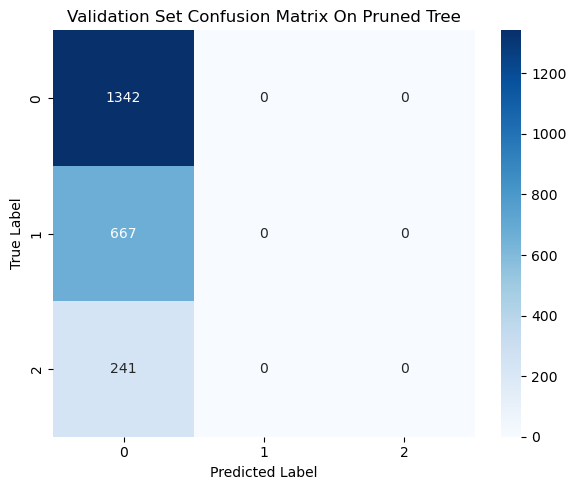

Accuracy: 0.5964
Precision per class:
  0: 0.5964
  1: 0.0000
  2: 0.0000
Recall per class:
  0: 1.0000
  1: 0.0000
  2: 0.0000
F1 Score per class:
  0: 0.7472
  1: 0.0000
  2: 0.0000
Macro Averages:
  Precision: 0.1988
  Recall:    0.3333
  F1 Score:  0.2491


In [47]:
from matplotlib import cm


def get_weakest_twigs_with_ig(tree, X_train, y_train, target_name, top_n=5, print_output=True):
    """Analyze the tree and return the top-n weakest twigs based on Information Gain"""
    full_data = pd.concat([X_train, y_train], axis=1)
    node_info = []

    def traverse(node, path=[]):
        if isinstance(node, dict):
            for feature, branches in node.items():
                subset = full_data.copy()
                for f, v in zip(path[::2], path[1::2]):
                    subset = subset[subset[f] == v]

                if subset.empty:
                    continue

                current_ig = info_gain(subset, feature, target_name)
                class_dist = subset[target_name].value_counts(normalize=True).to_dict()

                node_info.append({
                    'path': path + [feature],
                    'ig': current_ig,
                    'class_dist': class_dist,
                    'n_samples': len(subset)
                })

                for value, subtree in branches.items():
                    traverse(subtree, path + [feature, value])

    traverse(tree)

    node_report = pd.DataFrame(node_info).sort_values('ig').reset_index(drop=True)

    if print_output:
        print(f"\nTop {top_n} weakest paths to prune:")
        for i, row in node_report.head(top_n).iterrows():
            print(f"{i+1}. {' → '.join(map(str, row['path']))} (IG: {row['ig']:.4f}, Samples: {row['n_samples']})")

    return node_report.head(top_n)['path'].tolist()


def prune_paths_by_majority_class(tree, paths_to_prune, X_train, y_train, X_val, y_val, target_name):
    """Prune given paths and evaluate performance after each pruning"""
    current_tree = copy.deepcopy(tree)
    majority_class = y_train.mode()[0]

    # Helper: prune specific path
    def prune_path(tree, path):
        node = tree
        for step in path[:-1]:
            if isinstance(node, dict):
                node = node.get(step, {})
            else:
                return  # Early leaf reached

        last_feature = path[-1]
        subset = pd.concat([X_train, y_train], axis=1)
        for feature, value in zip(path[::2], path[1::2]):
            subset = subset[subset[feature] == value]

        majority = subset[target_name].mode()[0] if not subset.empty else majority_class

        if isinstance(node, dict) and last_feature in node:
            for val in node[last_feature]:
                node[last_feature][val] = majority

    # Function to calculate accuracy manually
    def manual_accuracy(y_true, y_pred):
        correct = 0
        for true, pred in zip(y_true, y_pred):
            if true == pred:
                correct += 1
        return correct / len(y_true) if len(y_true) > 0 else 0

    # Initial evaluation
    y_val_pred = predict_df(current_tree, X_val)
    y_val_pred = [pred if pred is not None else majority_class for pred in y_val_pred]
    last_acc = manual_accuracy(y_val, y_val_pred)
    print(f"\nInitial validation accuracy: {last_acc:.4f}")

    for i, path in enumerate(paths_to_prune, 1):
        print(f"\nPruning path {i}: {' → '.join(map(str, path))}")
        prune_path(current_tree, path)

        y_val_pred = predict_df(current_tree, X_val)
        y_val_pred = [pred if pred is not None else majority_class for pred in y_val_pred]
        current_acc = manual_accuracy(y_val, y_val_pred)
        print(f"New accuracy: {current_acc:.4f} (Δ{current_acc - last_acc:+.4f})")
        last_acc = current_acc

    return current_tree


# Step 1: Get weakest twigs
weakest_paths = get_weakest_twigs_with_ig(decision_tree, X_train, y_train, y_train.name, top_n=5)

# Step 2: Prune and evaluate
pruned_tree = prune_paths_by_majority_class(
    decision_tree,
    weakest_paths,
    X_train, y_train,
    X_val, y_val,
    y_train.name
)

# Final performance after pruning
print("\nFinal Pruned Tree Performance:")
y_val_pred = predict_df(pruned_tree, X_val)

# Replace None predictions with the most common class
y_val_pred = [p if p is not None else most_common_class for p in y_val_pred]

# Plot confusion matrix
cm_pruned, labels_pruned = plot_confusion_matrix(
    y_val, y_val_pred,
    "Validation Set Confusion Matrix On Pruned Tree"
)

# Calculate and print manual metrics instead of using classification_report
manual_metrics(cm_pruned, labels_pruned)
